Image shape: (512, 512, 104)
Data type: float64; Min: -1024.0; Max: 1444.0
Image2 shape: (512, 512, 424)
Data2 type: float64; Min: 0.0; Max: 1.0


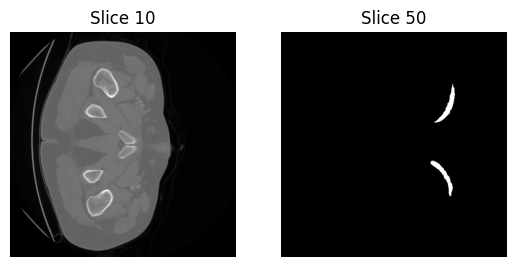

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt

# Load the .nii.gz file
file_path = '/home/shengzhang/data/nnUNet/gavin_vista3d/vista3d/example-1.nii.gz'
file_path2 = '../data/OSIC/imgs_20/33_0000.nii.gz'
file_path2 = '../data/OSIC/gt_20/33.nii.gz'
img = nib.load(file_path)
data = img.get_fdata()
print(f"Image shape: {data.shape}")
print(f"Data type: {data.dtype}; Min: {data.min()}; Max: {data.max()}")
try:
    img2 = nib.load(file_path2)
    data2 = img2.get_fdata()
    print(f"Image2 shape: {data2.shape}")
    print(f"Data2 type: {data2.dtype}; Min: {data2.min()}; Max: {data2.max()}")
except FileNotFoundError:
    pass

# Get the image data as a numpy array


# Display slices of the image
slice_index = data.shape[2] // 2  # Middle slice along the z-axis
slice_index = 10
plt.Figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(data[:, :, slice_index], cmap='gray')
plt.title(f'Slice {slice_index}')
plt.axis('off')
if 'data2' in locals():
    slice_index = 50
    plt.subplot(1, 2, 2)
    plt.imshow(data2[:, :, slice_index], cmap='gray')
    plt.title(f'Slice {slice_index}')
    plt.axis('off')
plt.show()

## Inference debugger

In [3]:
import os, sys
import copy
from tkinter import Tk, filedialog, messagebox

import fire
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from matplotlib.widgets import Button, TextBox
print('current dir:', os.getcwd())
if not os.getcwd().endswith('vista3d'):
    WORK_ROOT = os.path.dirname(os.getcwd()) #vista3d/
    os.chdir(WORK_ROOT)
    sys.path.insert(0,WORK_ROOT)

from monai.data import decollate_batch, list_data_collate, partition_dataset
from scripts.infer_debug import InferClass
from scripts.utils.workflow_utils import get_point_label

from scripts.sliding_window import point_based_window_inferer, sliding_window_inference
from scripts.utils.trans_utils import VistaPostTransform, get_largest_connected_component_point

inferer = InferClass(config_file=["configs/infer.yaml"])

current dir: /media/ssd1/zhangsheng/data/nnUNet/gavin_vista3d/vista3d
Current path: /media/ssd1/zhangsheng/data/nnUNet/gavin_vista3d/vista3d
Config file: ['configs/infer.yaml']
Override: {}
Args: {'config_file': ['configs/infer.yaml']}


In [ ]:
model = inferer.model
model.eval()

def infer_debug(
    self,
    image_file,
    point=None,
    point_label=None,
    label_prompt=None,
    prompt_class=None,
    save_mask=False,
    point_start=0,
):
    self.model.eval()
    if not isinstance(image_file, dict):
        image_file = {"image": image_file}
    if self.batch_data is not None:
        batch_data = self.batch_data
    else:
        batch_data = self.infer_transforms(image_file) # torch.Size([1, 308, 308, 344]), float32, (0,1)
        if label_prompt is not None:
            batch_data["label_prompt"] = label_prompt
        batch_data = list_data_collate([batch_data])
        self.batch_data = batch_data
        # if point is None
        self.sliding_window_inferer = sliding_window_inference
    device_list_input = [self.device, self.device, "cpu"]
    device_list_output = [self.device, "cpu", "cpu"]